# Qanvast, Interior Design Vendor Management System - Part 1

This personal project appeals to identify the top vendors and user sentiment across Interior Design (ID) Company in Singapore. Qanvast is a renovation platform for user to seek inspiration and get matched with vendor locally in Singapore based on the budget requirement and attain several vendor quotations for user review prior to engagement. 

Using Natural Language Processing to identify the sentiment and ratings across listed vendors and identify room for improvement, otherwise interference may be required to retain a pool of high-quality approved vendor list. 

# Notebook Brief

This notebook contains the data extraction, cleaning and basic exploratory on the data features. Preprocessing on reviews and text will be in upcoming notebook.

Note: If you have yet to see the next notebook, it is in progress at the moment. 

## 1.0 Data Extraction

Data is extracted from Qanvast website as follow. All private information are removed prior to any processing to protect user identity and information.

In [1]:
import requests
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)

Below function is commented after scrapping to avoid repeat data extraction. 

In [2]:
def convert_header(req_string):
    req_string = req_string.split('\n')[1:]
    header_dict = {line.split(':')[0]: line.split(':')[1].strip() for line in req_string}
    return header_dict

In [3]:
post_request = '''GET /api/user-review/listing/ HTTP/1.1
Accept: application/json
Content-Type: application/json
Cookie: __asc=bd23422717a510842d9ae6fe8b7; __auc=bf21b87917a50df6043af50805f; csrfToken=cXtdBKVT-kK44SBhmXIsOptiaAd7yYsdiKao; isAuthenticated=false; sessionId=s%3Aeb19fb42-b3f0-4223-bd40-018aaea69173.QVuB6G5fLwsSCoonpDjj7ZkG79U%2BTXvbONu51m9JLZY; userId=s%3A.2rfFf2Srfq8%2FKgdTCf9%2BPMzyieye72ZCLY64mCrGq%2F8; intercom-id-gcgemb36=ad2fc99e-5028-47bd-a2d7-5b60237d6e00; intercom-session-gcgemb36=; _fbp=fb.1.1624854454968.168919537; _ga=GA1.2.436750936.1624854457; _gid=GA1.2.35870100.1624854457; _uetsid=2a6e9f50d7c911eb8718c9003e1b58ba; _uetvid=2a6ed8a0d7c911ebacbe45d2212ae0e1; __atuvc=3%7C26; isRenoCalcShown=true; AWSELB=7DC7EFB112582530CA6573B705B4E49313D71D47E86026E5FB1B29DC6629DF7542A9A99EC36A882CF275AD69005BF24C1149C057CF3EEAF9A7E5D2BC1341D71B9162B2383A; AWSELBCORS=7DC7EFB112582530CA6573B705B4E49313D71D47E86026E5FB1B29DC6629DF7542A9A99EC36A882CF275AD69005BF24C1149C057CF3EEAF9A7E5D2BC1341D71B9162B2383A
Accept-Encoding: gzip, deflate, br
Host: qanvast.com
User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15
Referer: https://qanvast.com/sg/reviews
Accept-Language: en-sg
Connection: keep-alive
X-XSRF-TOKEN: cXtdBKVT-kK44SBhmXIsOptiaAd7yYsdiKao'''

headers = convert_header(post_request)

In [8]:
## EXTRACTING FILES COMMENTED DATED 28 JUN

final_dict = []
loop = 868
max_sleep_time = 10

for page_num in range(loop):
    sleep_time = random.random() * max_sleep_time
    remain_page = loop - page_num
    print('\rWaiting... {} loop remaining... '.format(remain_page), end='.')
    url = f'https://qanvast.com/api/user-review/listing/?page={page_num+1}&populate%5Buser%5D=true&populate%5Breviewee%5D=true&populate%5BprojectImages%5D=true'
    while True:
        try:
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                final_dict += response.json()['data']
                final_df = pd.DataFrame(final_dict)
                final_df.to_csv('./data/qanvast.csv', index=False)
                break
            else:
                print('Failed at loop #{}...'.format(page_num))
        except:
            continue
        break
    time.sleep(sleep_time)

Waiting... 1 loop remaining... ...

## 2.0 Data Cleaning 

Upon extraction, data imported for simple data cleaning to ensure the sanity of the extracted data. 

In [9]:
#read from extracted csv dated 28 Jun
final_df = pd.read_csv('./data/qanvast.csv')

In [10]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8680 entries, 0 to 8679
Data columns (total 29 columns):
id                         8680 non-null int64
content                    8680 non-null object
isPublished                8680 non-null bool
revieweeId                 8680 non-null int64
reviewerId                 5528 non-null float64
reviewOf                   8680 non-null object
projectCompletionDate      8680 non-null object
projectCost                1382 non-null float64
title                      8680 non-null object
country                    8678 non-null object
currency                   520 non-null object
designRating               8680 non-null int64
workmanshipRating          8680 non-null int64
professionalismRating      8680 non-null int64
projectManagementRating    8680 non-null int64
designerName               6762 non-null object
isVerified                 8680 non-null bool
revieweeResponse           22 non-null object
oneWeekEmail               8680 non-null

In [11]:
#dropna unlisted company in company col
final_df.dropna(subset=['company'], axis=0,inplace=True)

Column `company` contains a dictionary containing the interior designer company names. We will extract the company names and other information will not be kept.

In [12]:
# error handling for company col into dict
import ast
final_df['company'] = final_df['company'].apply(ast.literal_eval)

In [13]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8615 entries, 0 to 8679
Data columns (total 29 columns):
id                         8615 non-null int64
content                    8615 non-null object
isPublished                8615 non-null bool
revieweeId                 8615 non-null int64
reviewerId                 5463 non-null float64
reviewOf                   8615 non-null object
projectCompletionDate      8615 non-null object
projectCost                1380 non-null float64
title                      8615 non-null object
country                    8613 non-null object
currency                   520 non-null object
designRating               8615 non-null int64
workmanshipRating          8615 non-null int64
professionalismRating      8615 non-null int64
projectManagementRating    8615 non-null int64
designerName               6697 non-null object
isVerified                 8615 non-null bool
revieweeResponse           22 non-null object
oneWeekEmail               8615 non-null

In [14]:
#get company name from dict
final_df.company = final_df.company.apply(lambda x: x['name'])

In [15]:
final_df.columns

Index(['id', 'content', 'isPublished', 'revieweeId', 'reviewerId', 'reviewOf',
       'projectCompletionDate', 'projectCost', 'title', 'country', 'currency',
       'designRating', 'workmanshipRating', 'professionalismRating',
       'projectManagementRating', 'designerName', 'isVerified',
       'revieweeResponse', 'oneWeekEmail', 'offlineUserName',
       'qanvastResponse', 'createdAt', 'updatedAt', 'averageRating', 'Company',
       'reviewer', 'projectImages', 'company', 'unlistedCompany'],
      dtype='object')

Other columns are dropped as either they have lack of informative data and / or removed as ethical reasons due to privacy. 

In [16]:
#column selection
#drop cols
final_df = final_df.drop(columns=['id','currency', 'isPublished','revieweeId','reviewerId','reviewOf','isVerified','oneWeekEmail','offlineUserName','qanvastResponse','revieweeResponse','Company','reviewer','projectImages','unlistedCompany','updatedAt','designerName'])

In [17]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8615 entries, 0 to 8679
Data columns (total 12 columns):
content                    8615 non-null object
projectCompletionDate      8615 non-null object
projectCost                1380 non-null float64
title                      8615 non-null object
country                    8613 non-null object
designRating               8615 non-null int64
workmanshipRating          8615 non-null int64
professionalismRating      8615 non-null int64
projectManagementRating    8615 non-null int64
createdAt                  8615 non-null object
averageRating              8615 non-null float64
company                    8615 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 875.0+ KB


Above columns are retained for Exploratory Data Analysis.

## 3.0 Exploratory Data Analysis

### 3.1 Project Cost

Project Cost were note explicitly provided in most of the reviews and feedback. 7235 entries, close to 83% of the reviews does not have any cost / budget added. Hence, the following EDA applies only on the 6% dataset that we have.

In [18]:
#replace na with 0
final_df.projectCost.fillna(0,inplace=True)

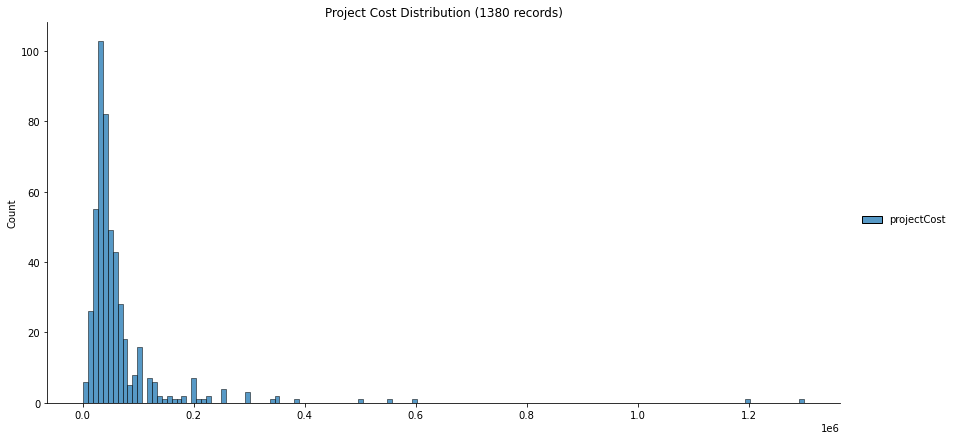

In [20]:
#plot data based on 6% available data 
temp_df = final_df[final_df.projectCost > 0][['projectCost']]

sns.displot(data=temp_df,aspect=2,height=6,)
plt.title('Project Cost Distribution (1380 records)')
plt.show()

In [21]:
temp_df.describe()

,projectCost
count,4.880000e+02
mean,6.589498e+04
std,1.004825e+05
min,1.500000e+03
25%,3.000000e+04
50%,4.000000e+04
75%,6.500000e+04
max,1.300000e+06


*Interpretation: Most cost are with mean at SGD 65,000. As the data does not contain information on the per sq feet involved in the renovation, hence the assumption does not stand for entire population.*

### 3.2 Country

Country location was assumed to be in Singapore. However there are several location that display other countries i.e. Malaysia and Hong Kong. 

In [22]:
#replace country with SG
final_df.country = final_df.country.fillna('SG')
final_df.reset_index(drop=True, inplace=True)

In [23]:
final_df.country.value_counts(normalize=True)

SG    0.952525
MY    0.040163
HK    0.007313
Name: country, dtype: float64

In [24]:
final_df[final_df.country != 'SG'].head()

,content,projectCompletionDate,projectCost,title,country,designRating,workmanshipRating,professionalismRating,projectManagementRating,createdAt,averageRating,company
67,"Thank you James, Goh and team..The best decisi...",2021-04-30T16:00:00.000Z,0.0,Highly recommended,MY,5,5,5,5,2021-06-19T02:31:17.726Z,5.0,DesignLah
84,Actually this is the second time we work with ...,2021-04-30T16:00:00.000Z,0.0,Fast & Reliable,MY,5,5,5,5,2021-06-14T11:44:51.529Z,5.0,Surface R Sdn. Bhd.
185,Thank you Edward & Josephine on my home renova...,2021-04-30T16:00:00.000Z,0.0,Professional Advise,MY,5,5,5,5,2021-05-04T07:58:39.833Z,5.0,Interior Choreographer Design (INC Design)
314,We engaged Dohson for minor make over for our ...,2021-03-31T16:00:00.000Z,0.0,Amazing work,MY,5,5,5,5,2021-04-21T02:55:49.372Z,5.0,Dohson Sdn. Bhd.
320,Blaine robert has an excellent team that cater...,2021-03-31T16:00:00.000Z,0.0,Excellent design team,MY,5,5,5,5,2021-04-19T04:48:35.868Z,5.0,Blaine Robert Design Sdn. Bhd.


### 3.3 Company

In [25]:
#remove chinese character
test = final_df.company.str.replace(r'[^\s\x00-\x7F ]+', '')
#remove white space
final_df.company = test.str.strip()

In [26]:
#sum reviews for each company 
total_reviews = pd.Series(final_df['company'].value_counts()).to_dict()
#input as column of total reviews
final_df['total_reviews'] = final_df.company.apply(total_reviews.get)

In [27]:
final_df.head(1)

,content,projectCompletionDate,projectCost,title,country,designRating,workmanshipRating,professionalismRating,projectManagementRating,createdAt,averageRating,company,total_reviews
0,I'm thankful to Thomas for providing a compreh...,2021-07-31T16:00:00.000Z,0.0,Review of Thomas from Todz'Terior,SG,5,5,5,5,2021-05-31T13:44:41.680Z,5.0,TodzTerior,18


### 3.4 Completion Date and Posted date

The completiond data would indicate the project distribution and urgency. We can overlap this with event of BTO (Built-To-Order) completion and the demand on the renovation services throughout the seasons.

In [28]:
#func to convert values to datetime format
def convert_dt(df, col):
    df[col] = pd.to_datetime(df[col])

In [29]:
#convert completion time, created review and updated review time
convert_dt(final_df, 'projectCompletionDate')
convert_dt(final_df, 'createdAt')

In [30]:
final_df.createdAt.dt.date.min(), final_df.createdAt.dt.date.max()

(datetime.date(2014, 10, 13), datetime.date(2021, 6, 28))

In [31]:
final_df.projectCompletionDate.dt.date.min(), final_df.projectCompletionDate.dt.date.max()

(datetime.date(2015, 9, 30), datetime.date(2021, 7, 31))

Some reviews are posted as mid-reno review.

In [32]:
final_df[final_df.createdAt < final_df.projectCompletionDate]['content'].values[10:15]

array(['Vanessa was professional and showed creativity through her layout ideas and designs before we finalised with most suitable one for us. \r\n\r\nDuring on going renovation works, she was responsive to our queries. Any rectification works we also followed up quite quickly.\r\n\r\nThis was an enjoyable and fuss free renovation experience I had. Am happy to finally have my dream home!',
       'Very Happy with our renovation experience and result. Would definitely recommend WeiLu and Ean for their patience throughout our renovation journey. Giving us ideals and solving unforeseen problems upon renovation. Big thumbs up for the good quality and workmanship from Happe Design Atelier! Would definitely recommend to anyone who are looking for quality work and interesting design  to approach HDA designers as their ID.. Fun group of people:))',
       "We had an extremely pleasant and enjoyable experience working with Happe's Kelvyn, David and Edwin. They were able to propose functional an

In [33]:
# reset index after remove na
final_df.reset_index(drop=True, inplace=True)

In [34]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8615 entries, 0 to 8614
Data columns (total 13 columns):
content                    8615 non-null object
projectCompletionDate      8615 non-null datetime64[ns, UTC]
projectCost                8615 non-null float64
title                      8615 non-null object
country                    8615 non-null object
designRating               8615 non-null int64
workmanshipRating          8615 non-null int64
professionalismRating      8615 non-null int64
projectManagementRating    8615 non-null int64
createdAt                  8615 non-null datetime64[ns, UTC]
averageRating              8615 non-null float64
company                    8615 non-null object
total_reviews              8615 non-null int64
dtypes: datetime64[ns, UTC](2), float64(2), int64(5), object(4)
memory usage: 875.1+ KB


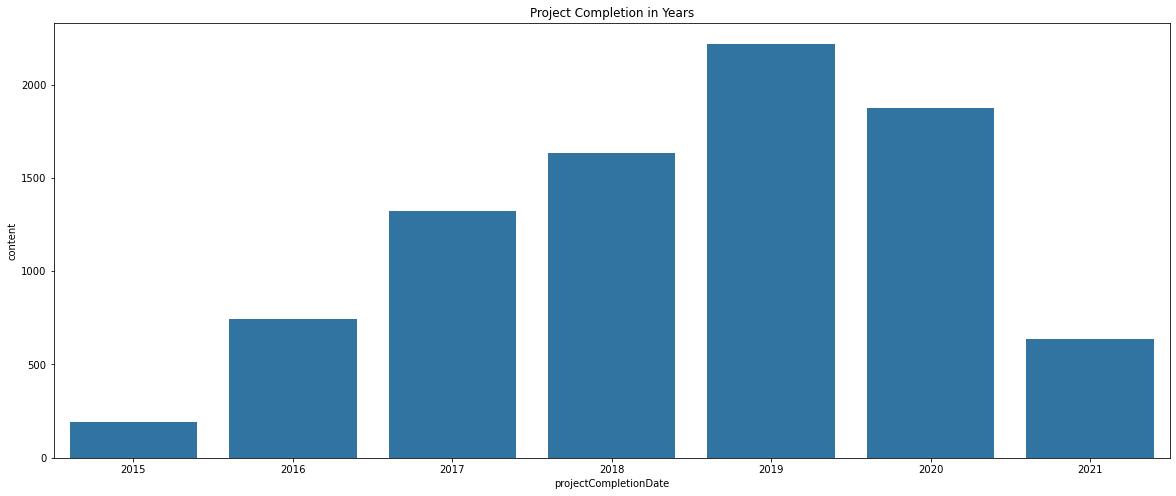

In [35]:
#project completion count
plt.figure(figsize=(20,8))
temp_df = final_df.resample('Y', on='projectCompletionDate').count()[['content']].reset_index()
sns.barplot(data=temp_df, x=temp_df.projectCompletionDate.dt.year, y= temp_df.content, color='tab:blue')
plt.title('Project Completion in Years')
plt.show()

*Interpretation: The reviews span from 2015 up till date (Jun 2021). The growing use of Qanvast as a medium is more prominent and peaks in 2019. The dip is likely due to the Covid-19 restriction that has slowed down vendors engagement in renovation activity.*

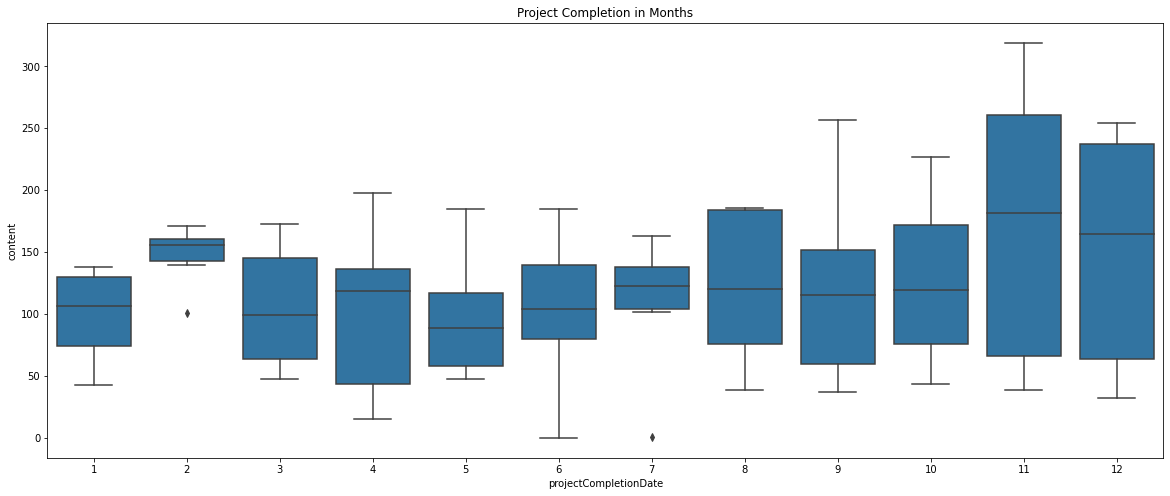

In [36]:
#completion by months
plt.figure(figsize=(20,8))
temp_df = final_df.resample('M', on='projectCompletionDate').count()[['content']].reset_index()
sns.boxplot(data=temp_df, x=temp_df.projectCompletionDate.dt.month, y= temp_df.content, color='tab:blue')
plt.title('Project Completion in Months')
plt.show()

*Interpretation: Regardless of the years, the renovation are active throughout the years and especially active for completion by end of the year. The possible reasons on the completion could be due to year end financial closing for the vendors or the users preference to be able to move in by the end of the year before the new year.*

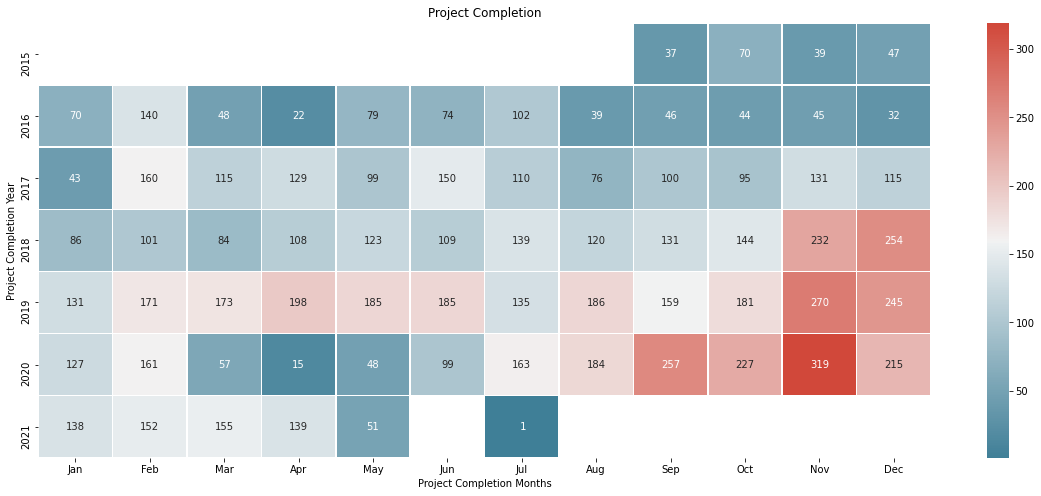

In [37]:
plt.figure(figsize=(20,8))
cmap = sns.diverging_palette(225,15,as_cmap=True)
temp_df = final_df.groupby([(final_df.projectCompletionDate.dt.year),(final_df.projectCompletionDate.dt.month)]).count()[['content']].unstack()
sns.heatmap(data=temp_df, annot=True, cmap=cmap, linewidths=.5, xticklabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], fmt='2g')
plt.title('Project Completion')
plt.ylabel('Project Completion Year')
plt.xlabel('Project Completion Months')
plt.show()

*Interpretation: There is indeed a preference in project completion by end of the year. There is also a huge spike in 2020 Nov. I reckon this is driven by back-logs from the Mar 2020 onwards. This is likely as the Circuit Breaker restriction kicked in on Apr 2020, putting a halt in a lot of home renovations for a month. The works were on a slow comeback and as the tight covid restrictions are lifted closer to the end of the year, the hustle to completion are prominent in 2020. The same scenario has applied again in 2021, where restriction is imposed in May 2021.*

### 3.5 Reviews and Ratings

In [38]:
final_df.head(1)

,content,projectCompletionDate,projectCost,title,country,designRating,workmanshipRating,professionalismRating,projectManagementRating,createdAt,averageRating,company,total_reviews
0,I'm thankful to Thomas for providing a compreh...,2021-07-31 16:00:00+00:00,0.0,Review of Thomas from Todz'Terior,SG,5,5,5,5,2021-05-31 13:44:41.680000+00:00,5.0,TodzTerior,18


In [39]:
#combined title and comment text
final_df['reviews'] = final_df.title + ' ' + final_df.content

#drop title and content column
final_df.drop(columns=['title','content'], inplace=True)

In [40]:
final_df.reviews.head()

0    Review of Thomas from Todz'Terior I'm thankful...
1    Beautiful home thanks to MSS! Big thank you to...
2    Attention to details and stress-free experienc...
3    GREAT WORK -JIN LING, PROJECT GURU Prior to en...
4    An Average ID Firm The first meet up went very...
Name: reviews, dtype: object

In [41]:
#identity word count length
final_df['word_count'] = [len(final_df.reviews[i].split()) for i in range(final_df.shape[0])]

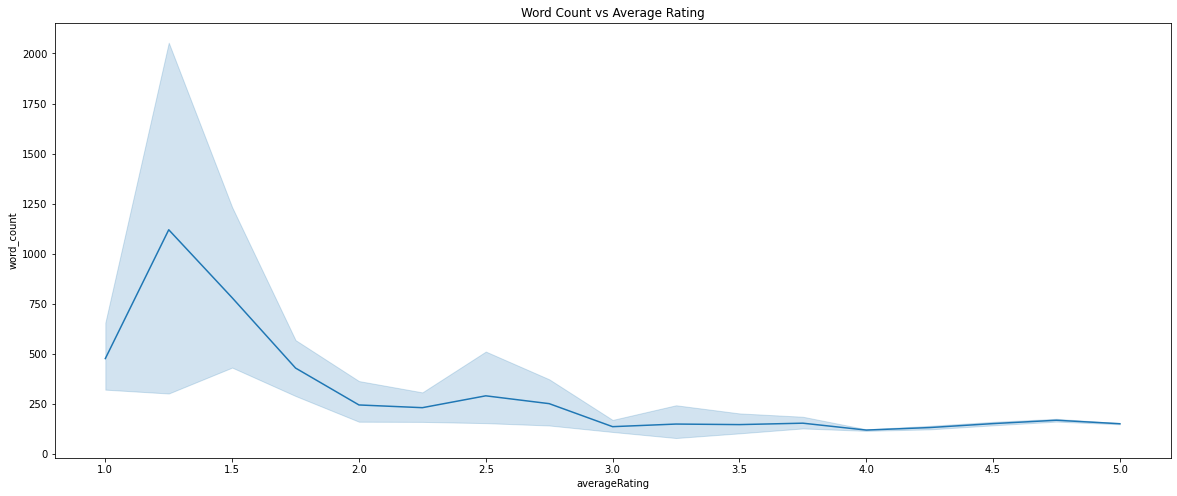

In [42]:
#average rating vs word count
plt.figure(figsize=(20,8))
sns.lineplot(data=final_df, x='averageRating', y='word_count')
plt.title('Word Count vs Average Rating')
plt.show()

*Interpretation: Naturally as the services receive by users is not satisfactory, the comments and feedback is long with detail on how or why the vendor is not within acceptance. This is also opportune to review on the comments and look for improvement and reason on the disatisfaction and take necessary action.*

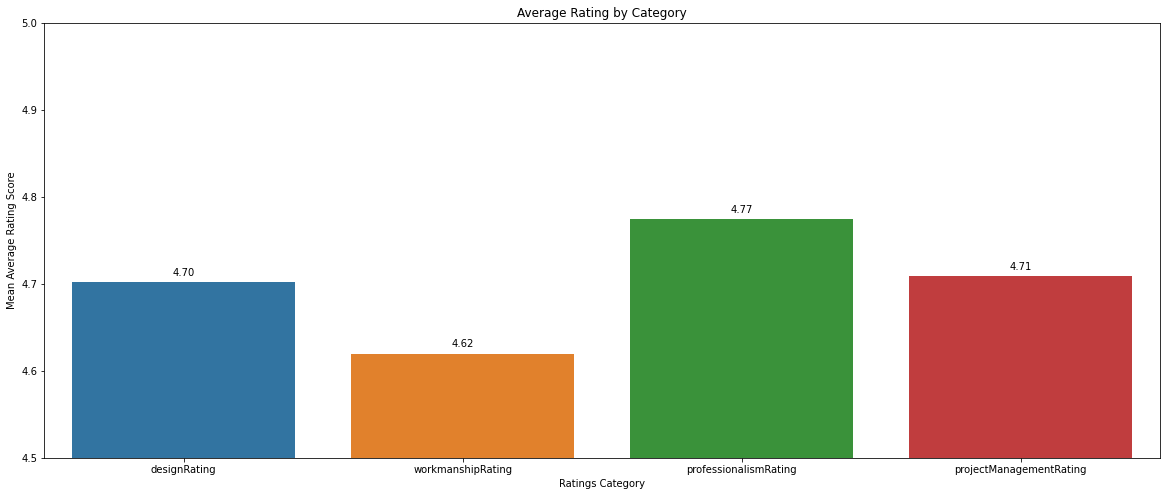

In [43]:
#isloate rating columns
temp_df = final_df[['designRating','workmanshipRating','professionalismRating','projectManagementRating']]
temp_df = temp_df.mean(axis=0).reset_index().rename(columns={'index':'ratingtype', 0:'averating'})
plt.figure(figsize=(20, 8))
graph= sns.barplot(data=temp_df, x='ratingtype', y ='averating')
plt.ylim(4.5,5)
plt.title('Average Rating by Category')
plt.ylabel('Mean Average Rating Score')
plt.xlabel('Ratings Category')

#annotation
for p in graph.patches:
    graph.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.40, p.get_height()+0.005),
                ha='center', va='bottom',
               color= 'black')
plt.show()

*Interpretation: Workmanship has the lowest average score compared to other category whereas Professionalism scores the highest in average on all reviews, with Project Management follow closely next.*

More exploratory on the text reviews using natural languare processing will be conducted in the next notebook.

## 4.0 Cleaned Data Export

In [44]:
final_df.to_csv('./data/cleaned_qvst.csv',index=False)